In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi 
from skimage.color import rgb2gray
from skimage import io, color, filters, util, data, transform, feature

In [3]:
def gaussian_blur(image, sigma=1.0):
    image_blurred = ndi.gaussian_filter(image, sigma=sigma)
    return image_blurred


def sobel_gradients(image):
    
    # return gradient images using sobel filter
    Gx = ndi.sobel(image, axis=1)  # sobel x derivative (same size as image)
    Gy = ndi.sobel(image, axis=0)  # sobel y derivative (same size as image)
    magnitude = np.sqrt(Gx**2 + Gy**2)  # gradient magnitude (same size as image)
    orientation = np.arctan2(Gy, Gx)  # gradient orientation, MUST be radians (same size as image)
 
    return Gx, Gy, magnitude, orientation


def non_maximum_suppression(G, theta):
    H, W = G.shape
    Z = np.zeros((H, W), dtype=np.float32)

    angle = (np.rad2deg(theta) + 180) % 180 # convert orientation to degrees in [0, 180)

    for i in range(1, H - 1):
        for j in range(1, W - 1):
            q = 255
            r = 255
            # quantize orientation into 4 bins:
            # angle 0
            if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                q = G[i, j + 1]
                r = G[i, j - 1]
            # angle 45
            elif 22.5 <= angle[i, j] < 67.5:
                q = G[i + 1, j - 1]
                r = G[i - 1, j + 1]
            # angle 90
            elif 67.5 <= angle[i, j] < 112.5:
                q = G[i + 1, j]
                r = G[i - 1, j]
            # angle 135
            elif 112.5 <= angle[i, j] < 157.5:
                q = G[i - 1, j - 1]
                r = G[i + 1, j + 1]

            if (G[i, j] >= q) and (G[i, j] >= r):
                Z[i, j] = G[i, j]
            else:
                Z[i, j] = 0
    return Z


def hysteresis_thresholding(nms, low_ratio=0.01, high_ratio=0.2):
    high_th = nms.max() * high_ratio
    low_th = nms.max() * low_ratio

    strong = nms >= high_th
    weak = (nms >= low_th) & (nms < high_th)

    edges = np.zeros_like(nms, dtype=bool)
    edges[strong] = True

    # Iterative edge linking: promote weak pixels connected to strong
    changed = True
    while changed:
        changed = False
        weak_neighbors = np.logical_and(weak, ndi.binary_dilation(edges))
        new_edges = weak_neighbors & ~edges
        if np.any(new_edges):
            edges[new_edges] = True
            changed = True

    return edges

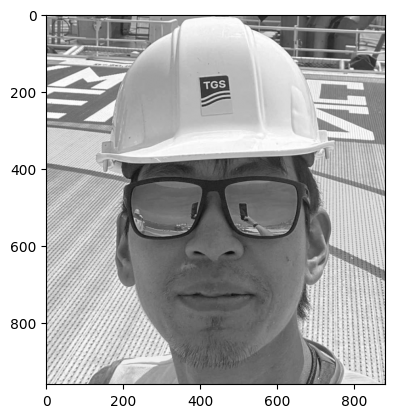

In [ ]:

img = io.imread('newpics/me.png')
img = rgb2gray(img)a
img = util.img_as_float32(img)
plt.imshow(img, cmap='gray')

Text(0.5, 1.0, 'canny skimage edges')

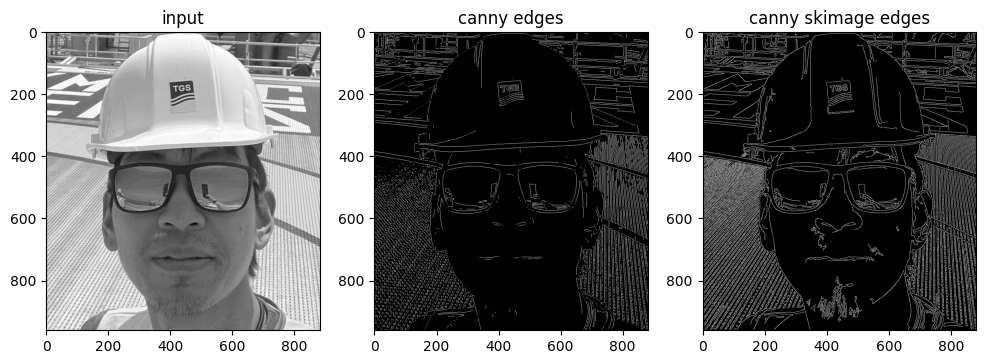

In [5]:
# Canny edge detection
sigma=1.4
low_threshold=0.001
high_threshold=0.2

# canny algorithm steps
blurred = gaussian_blur(img, sigma)
Gx, Gy, G, theta = sobel_gradients(blurred)
nms = non_maximum_suppression(G, theta)
edges = hysteresis_thresholding(nms, low_threshold, high_threshold)

# canny algorithm from skimage
edge_canny = feature.canny(img, sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
ax[0].imshow(img, cmap="gray")
ax[0].set_title("input")
ax[1].imshow(edges, cmap="gray")
ax[1].set_title("canny edges")
ax[2].imshow(edge_canny, cmap="gray")
ax[2].set_title("canny skimage edges")